# Mapping avocado prices in the United States

In [20]:
# Importing libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline 
#So our plots display in the jupyter notebook environment

# Importing our data
data = pd.read_csv('avocado.csv', index_col = 'Date')

In [21]:
# Let's inspect the data
display(data.head())

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-12-27,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [22]:
# That's too much data, we don't need all of that. We want to make a heat map based on price and region. 
# Let's drop some columns!

columns_to_drop = ['Unnamed: 0', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type']

avo_df = data.drop(columns_to_drop, axis=1)
display(avo_df.head())

,AveragePrice,Total Volume,year,region
Date,,,,
2015-12-27,1.33,64236.62,2015,Albany
2015-12-20,1.35,54876.98,2015,Albany
2015-12-13,0.93,118220.22,2015,Albany
2015-12-06,1.08,78992.15,2015,Albany
2015-11-29,1.28,51039.60,2015,Albany


In [23]:
# That's better! Now let's identify the unique values in the region column.

regions = avo_df.region.unique()

print(regions)

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


In [24]:
# Let's do a little statistical EDA!
# This gives us an idea of the shape of our data


print('Maximum = ' + str(avo_df.AveragePrice.max()))
print('Mean = ' + str(avo_df.AveragePrice.mean()))
print('Median = ' + str(avo_df.AveragePrice.median()))
print('Minimum = ' + str(avo_df.AveragePrice.min()))
print('Standard Deviation = ' +str(avo_df.AveragePrice.std()))

Maximum = 3.25
Mean = 1.4059784097758825
Median = 1.37
Minimum = 0.44
Standard Deviation = 0.40267655549555004


In [25]:
# Where are the cheapest and most expensive avocados in our dataset?

display(avo_df[avo_df.AveragePrice == avo_df.AveragePrice.min()])
display(avo_df[avo_df.AveragePrice == avo_df.AveragePrice.max()])

,AveragePrice,Total Volume,year,region
Date,,,,
2017-03-05,0.44,64057.04,2017,CincinnatiDayton


,AveragePrice,Total Volume,year,region
Date,,,,
2016-10-30,3.25,16700.94,2016,SanFrancisco


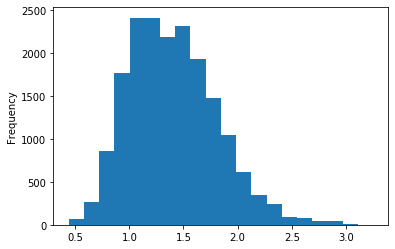

In [26]:
# Let's do some Visual EDA! 
# Let's see the distribution of prices

avo_df['AveragePrice'].plot(kind='hist', bins=20)

In [27]:
# Let's create a new DataFrame with just one value (the mean of the average prices) for each region.

group_by_region = avo_df.groupby(by=['region'])
avo_df_avg = group_by_region.mean()
avo_df_avg = avo_df_avg.drop(['year'], axis=1)

print(avo_df_avg.head())


                     AveragePrice   Total Volume
region                                          
Albany                   1.561036   47537.869734
Atlanta                  1.337959  262145.322041
BaltimoreWashington      1.534231  398561.891479
Boise                    1.348136   42642.567308
Boston                   1.530888  287792.854527


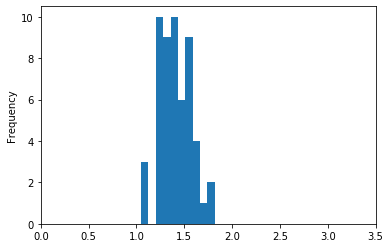

In [28]:
# Let's do some Visual EDA! 
# Let's see the distribution of prices for our new smaller dataset to see if the distribution looks roughly the same

avo_df_avg['AveragePrice'].plot(kind='hist', xlim=(0,3.5), bins=10)

# We see that the peak is in the same area but that most of the outliers have been removed, as expected. There are much
# fewer datapoints in our new DataFrame as well, as we have reduced everything to one mean figure for each region for 
# each year

In [13]:
# OK - Now to pull in geodata for each of our regions using geopy. We can take just the region name and geocode that. I'm
# using Bing Maps because I have a Bing Maps API key and I found it most responsive when testing, but there are others
# available - Nominatim is a good free choice which doesn't require an API Key.

from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter


geolocator = Bing(api_key='GetYourOwnAPIKeyYouScallywag', timeout=30)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2) # This prevents overloading the API with requests, but adds time to the process


regions_dict = {i : geolocator.geocode(i) for i in regions}

print(regions_dict)

{'Albany': Location(Albany, NY, United States, (42.65155029296875, -73.75521087646484, 0.0)), 'Atlanta': Location(Atlanta, GA, United States, (33.74831008911133, -84.39111328125, 0.0)), 'BaltimoreWashington': Location(MD, United States, (39.183738708496094, -76.67420959472656, 0.0)), 'Boise': Location(Boise, ID, United States, (43.60768127441406, -116.19339752197266, 0.0)), 'Boston': Location(Boston, MA, United States, (42.35866165161133, -71.0567398071289, 0.0)), 'BuffaloRochester': Location(Buffalo, NY, United States, (42.885440826416016, -78.87846374511719, 0.0)), 'California': Location(CA, United States, (37.25510025024414, -119.61752319335938, 0.0)), 'Charlotte': Location(Charlotte, NC, United States, (35.22285842895508, -80.83795928955078, 0.0)), 'Chicago': Location(Chicago, IL, United States, (41.88425064086914, -87.6324462890625, 0.0)), 'CincinnatiDayton': Location(Cincinnati, OH, United States, (39.10712814331055, -84.5041275024414, 0.0)), 'Columbus': Location(Columbus, OH, Un

In [14]:
# Becasue I'm paranoid about not being able to pull this data from the Bing Maps API again, I want to save 
# this dictionary as a file. Let's use pickle to do that!

import pickle


pickle_out = open("dict.pickle","wb")
pickle.dump(regions_dict, pickle_out)
pickle_out.close()

In [29]:
# Let's bring it back in from its pickled form
import pickle 

pickle_in = open("dict.pickle","rb")
regions_dict_new = pickle.load(pickle_in)

In [30]:
# Now we'll create a DataFrame from our dictionary.

regions_df = pd.DataFrame(regions_dict_new)

display(regions_df.head())

,Albany,Atlanta,BaltimoreWashington,Boise,Boston,BuffaloRochester,California,Charlotte,Chicago,CincinnatiDayton,...,SouthCarolina,SouthCentral,Southeast,Spokane,StLouis,Syracuse,Tampa,TotalUS,West,WestTexNewMexico
0,"Albany, NY, United States","Atlanta, GA, United States","MD, United States","Boise, ID, United States","Boston, MA, United States","Buffalo, NY, United States","CA, United States","Charlotte, NC, United States","Chicago, IL, United States","Cincinnati, OH, United States",...,"SC, United States","Dallas, TX, United States",United States,"Spokane, WA, United States","St Louis, MO, United States","Syracuse, NY, United States","Tampa, FL, United States",None,"Western, Zambia","NM, United States"
1,"(42.65155029296875, -73.75521087646484)","(33.74831008911133, -84.39111328125)","(39.183738708496094, -76.67420959472656)","(43.60768127441406, -116.19339752197266)","(42.35866165161133, -71.0567398071289)","(42.885440826416016, -78.87846374511719)","(37.25510025024414, -119.61752319335938)","(35.22285842895508, -80.83795928955078)","(41.88425064086914, -87.6324462890625)","(39.10712814331055, -84.5041275024414)",...,"(33.90385437011719, -80.89376831054688)","(32.71738815307617, -96.74552154541016)","(34.0, -85.0)","(47.65726089477539, -117.41227722167969)","(38.627750396728516, -90.1995620727539)","(43.050418853759766, -76.14737701416016)","(27.946529388427734, -82.45926666259766)",None,"(-15.655529975891113, 23.671653747558594)","(34.421321868896484, -106.10840606689453)"


In [31]:
# Now I want to re-arrange this DF to make it long and tall instead of short and wide (so I'll melt it), and at the same
# time drop the first row, as it's only the co-ordinates that I'm interested in.

regions_df_melted = regions_df.iloc[1:2,:].melt()
regions_df_melted.columns = ['region', 'co-ordinates'] # give the columns meaningful names

display(regions_df_melted.head())

,region,co-ordinates
0,Albany,"(42.65155029296875, -73.75521087646484)"
1,Atlanta,"(33.74831008911133, -84.39111328125)"
2,BaltimoreWashington,"(39.183738708496094, -76.67420959472656)"
3,Boise,"(43.60768127441406, -116.19339752197266)"
4,Boston,"(42.35866165161133, -71.0567398071289)"


In [32]:
# Now I want to add these two DataFrames (avo_df_avg - containing the price data, and regions_df_melted - containing 
# the co-ordinates)

df = pd.merge(avo_df_avg, regions_df_melted, left_on='region', right_on='region')
display(df.head())

,region,AveragePrice,Total Volume,co-ordinates
0,Albany,1.561036,47537.869734,"(42.65155029296875, -73.75521087646484)"
1,Atlanta,1.337959,262145.322041,"(33.74831008911133, -84.39111328125)"
2,BaltimoreWashington,1.534231,398561.891479,"(39.183738708496094, -76.67420959472656)"
3,Boise,1.348136,42642.567308,"(43.60768127441406, -116.19339752197266)"
4,Boston,1.530888,287792.854527,"(42.35866165161133, -71.0567398071289)"


In [33]:
# geopandas is going to want separate latitude and longitude columns for its points_from_xy function,
# so let's create those now.

df[['latitude', 'longitude']] = pd.DataFrame(df['co-ordinates'].tolist(), index=df.index)
print(df.head())

                region  AveragePrice   Total Volume  \
0               Albany      1.561036   47537.869734   
1              Atlanta      1.337959  262145.322041   
2  BaltimoreWashington      1.534231  398561.891479   
3                Boise      1.348136   42642.567308   
4               Boston      1.530888  287792.854527   

                               co-ordinates   latitude   longitude  
0   (42.65155029296875, -73.75521087646484)  42.651550  -73.755211  
1      (33.74831008911133, -84.39111328125)  33.748310  -84.391113  
2  (39.183738708496094, -76.67420959472656)  39.183739  -76.674210  
3  (43.60768127441406, -116.19339752197266)  43.607681 -116.193398  
4    (42.35866165161133, -71.0567398071289)  42.358662  -71.056740  


,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude,geometry
0,Albany,1.561036,47537.869734,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211,POINT (-73.75521 42.65155)
1,Atlanta,1.337959,262145.322041,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113,POINT (-84.39111 33.74831)
2,BaltimoreWashington,1.534231,398561.891479,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210,POINT (-76.67421 39.18374)
3,Boise,1.348136,42642.567308,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398,POINT (-116.19340 43.60768)
4,Boston,1.530888,287792.854527,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740,POINT (-71.05674 42.35866)


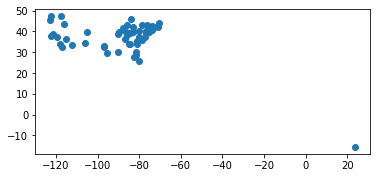

In [35]:
# Now to convert our pandas DataFrame into a geopandas GeoDataFrame

avo_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

display(avo_gdf.head())

avo_gdf.plot()

In [36]:
# Now we need to import Point and Polygon from shapely so that geopandas can use our US State shape files (sourced from
# the US Census Office)

from shapely.geometry import Point, Polygon

usa = gpd.read_file('tl_2017_us_state.shp')
print(usa.head())

  REGION DIVISION STATEFP   STATENS GEOID STUSPS           NAME LSAD  MTFCC  \
0      3        5      54  01779805    54     WV  West Virginia   00  G4000   
1      3        5      12  00294478    12     FL        Florida   00  G4000   
2      2        3      17  01779784    17     IL       Illinois   00  G4000   
3      2        4      27  00662849    27     MN      Minnesota   00  G4000   
4      3        5      24  01714934    24     MD       Maryland   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A   62265662566    489840834  +38.6472854  -080.6183274   
1        A  138911437206  31398800291  +28.4574302  -082.4091478   
2        A  143784114293   6211277447  +40.1028754  -089.1526108   
3        A  206229176104  18944967530  +46.3158148  -094.1996628   
4        A   25150696145   6980371026  +38.9466584  -076.6744939   

                                            geometry  
0  POLYGON ((-81.74725 39.09538, -81.74635 39.096...  
1  MUL

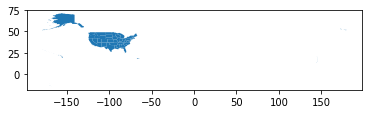

In [37]:
# Let's take a look at this shapefile and see what we've got here

usa.plot()

#### OK - So we have some of the USA's overseas territories here making our map crazily big. Let's see exactly what's in this Shape file. Our avocado data is only from the mainland United States, so we might need to trim this file to get a nice visualisation going.

In [39]:
print(usa.shape)
print(usa.NAME)

(56, 15)
0                                    West Virginia
1                                          Florida
2                                         Illinois
3                                        Minnesota
4                                         Maryland
5                                     Rhode Island
6                                            Idaho
7                                    New Hampshire
8                                   North Carolina
9                                          Vermont
10                                     Connecticut
11                                        Delaware
12                                      New Mexico
13                                      California
14                                      New Jersey
15                                       Wisconsin
16                                          Oregon
17                                        Nebraska
18                                    Pennsylvania
19                    

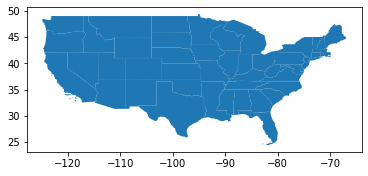

In [40]:
# Let's lose the entries we don't need

to_drop = ['Commonwealth of the Northern Mariana Islands', 'United States Virgin Islands', 
           'Hawaii', 'Alaska', 'Guam', 'Puerto Rico', 'American Samoa']

for index, row in usa.iterrows():
    if row['NAME'] in to_drop :
        usa.drop(index, inplace=True)

usa.plot()

# That's better!

In [41]:
# We want to make the latitude and longitude columns floats here to make our lives easier, and let's inspect our data

df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

display(df)

,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude,geometry
0,Albany,1.561036,4.753787e+04,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211,POINT (-73.75521 42.65155)
1,Atlanta,1.337959,2.621453e+05,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113,POINT (-84.39111 33.74831)
2,BaltimoreWashington,1.534231,3.985619e+05,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210,POINT (-76.67421 39.18374)
3,Boise,1.348136,4.264257e+04,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398,POINT (-116.19340 43.60768)
4,Boston,1.530888,2.877929e+05,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740,POINT (-71.05674 42.35866)
5,BuffaloRochester,1.516834,6.793630e+04,"(42.885440826416016, -78.87846374511719)",42.885441,-78.878464,POINT (-78.87846 42.88544)
6,California,1.395325,3.044324e+06,"(37.25510025024414, -119.61752319335938)",37.255100,-119.617523,POINT (-119.61752 37.25510)
7,Charlotte,1.606036,1.051939e+05,"(35.22285842895508, -80.83795928955078)",35.222858,-80.837959,POINT (-80.83796 35.22286)
8,Chicago,1.556775,3.955690e+05,"(41.88425064086914, -87.6324462890625)",41.884251,-87.632446,POINT (-87.63245 41.88425)
9,CincinnatiDayton,1.209201,1.317219e+05,"(39.10712814331055, -84.5041275024414)",39.107128,-84.504128,POINT (-84.50413 39.10713)


#### Some of these are NaNs or look suspiciously round or otherwise mysterious - this is because our original data from the Hass Avocado Board includes several entries for larger regions and the total US ('MidSouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West').

#### These need to be removed from our dataset, as they are duplicates and are going to cause us problems. It's always a good idea to understand your dataset. In this case, better late than never!

In [50]:
to_drop = ['Midsouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West']

for index, row in df.iterrows():
    if row['region'] in to_drop :
        df.drop(index, inplace=True)
#        
print(df)

                 region  AveragePrice  Total Volume  \
0                Albany      1.561036  4.753787e+04   
1               Atlanta      1.337959  2.621453e+05   
2   BaltimoreWashington      1.534231  3.985619e+05   
3                 Boise      1.348136  4.264257e+04   
4                Boston      1.530888  2.877929e+05   
5      BuffaloRochester      1.516834  6.793630e+04   
6            California      1.395325  3.044324e+06   
7             Charlotte      1.606036  1.051939e+05   
8               Chicago      1.556775  3.955690e+05   
9      CincinnatiDayton      1.209201  1.317219e+05   
10             Columbus      1.252781  8.873776e+04   
11        DallasFtWorth      1.085592  6.166251e+05   
12               Denver      1.218580  4.109542e+05   
13              Detroit      1.276095  1.876403e+05   
14          GrandRapids      1.505000  8.938383e+04   
15           GreatLakes      1.338550  1.744505e+06   
16   HarrisburgScranton      1.513284  1.236948e+05   
17  Hartfo

In [51]:
# Now the real fun begins! Let's convert our DataFrames to GeoDataFrames.

crs = {'init': 'epsg:4326'} # crs is the coordinate reference system - it's best to have both gdfs using the same one
avo_gdf = gpd.GeoDataFrame(df, crs=crs)
usa_gdf = gpd.GeoDataFrame(usa, crs=crs)

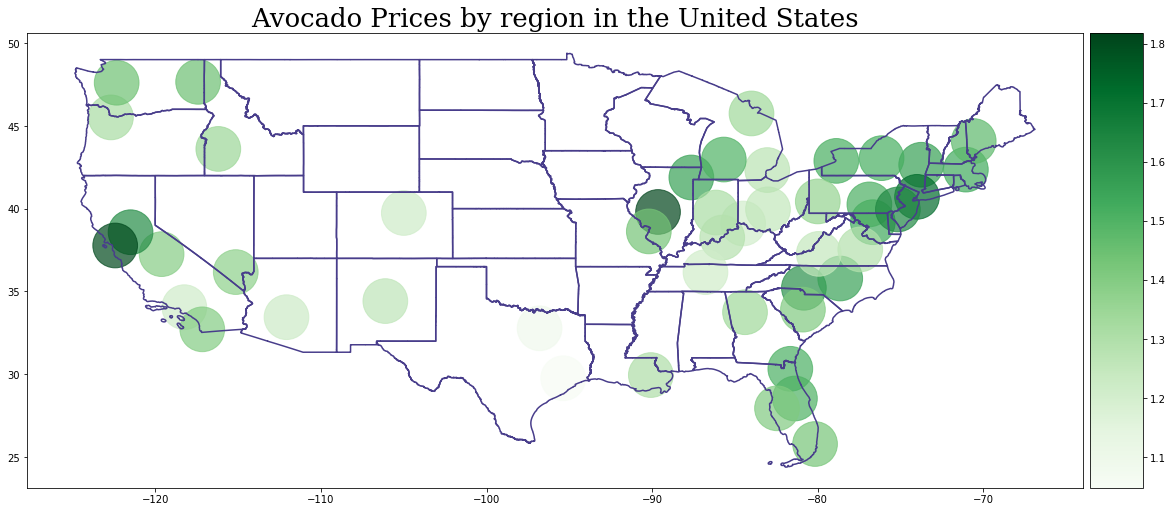

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # This is a function to allow us to make the legend pretty

fig, ax = plt.subplots(figsize = (20,16)) 
plt.title('Avocado Prices by region in the United States', fontsize=26, fontfamily='serif')

#this part makes the legend the same size as our map, for prettiness
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

usa.boundary.plot(ax=ax, color='DarkSlateBlue') # using the boundary method here to get the outlines of the states, an aesthetic decision
avo_gdf.plot(cmap='Greens', column='AveragePrice', legend=True, ax=ax, s=2000, alpha=0.7, cax=cax)


# this saves a copy of the viz as a jpg so we can easily share it with our friends on twitter!
plt.savefig('Avocado Prices.jpg', format='jpg') 